# Copyright Netherlands eScience Center <br>
** Function     : Clustering the patterns of climate fields from reanalyses ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.12.17 ** <br>
** Last Update  : 2018.12.17 ** <br>
Description     : The script aims to implement machine learning to cluster the different patterns given by the variable fields from reanalyses. Some fields are organized as patterns by the climate system (such as SLP, z500). Point-wise analysis then is not as powerful as the clustering methods so as to decrypt the data. Here we will use K-mean clustering to work on the SLP fields in the polar circle.<br>

Return Values   : png <br>
Dependencies    : os, time, numpy, netCDF4, sys, matplotlib <br>
variables       : SLP <br>
Caveat          : Due to the nature of clustering methods used here, we have to do multiple tests to make sure that the results we obtained are not due to the "unlucky" initialization.<br>

In [1]:
import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from scipy import stats
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import iris
import iris.plot as iplt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# constants
constant = {'g' : 9.80616,          # gravititional acceleration [m / s2]
            'R' : 6371009,          # radius of the earth [m]
            'cp': 1004.64,          # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,          # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,        # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,        # gas constant for water vapour [J/(kg*K)]
            'omega' : 7.2921*1E-5,  # Roration rate of the earth [rad/s]
            'rho_air' : 1.225,      # Surface air density [kg/m3]
            'Cd' : 1.56,            # Drag coefficient of 10m wind at 15 Celsius - from Stuart Smith 1988
            }

In [3]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    # AMET
    datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/postprocessing'
    datapath_MERRA2 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/MERRA2/postprocessing'
    datapath_JRA55 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/JRA55/postprocessing'
    # fields
    datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    datapath_MERRA2_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/MERRA2/regression'
    datapath_JRA55_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/JRA55/regression'
    datapath_ORAS4_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4/regression'
    output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/AMET_OMET/figures/revision/patterns'
    #####################################################################################
    print ('****************************************************************************')
    print ('********************    latitude index of insteret     *********************')
    print ('****************************************************************************')
    # 60N
    lat_ERAI_60 = 40
    lat_MERRA2_60 = 80 # after a first cut-off to 20N-90N
    lat_JRA55_60 = 53
    print ('*********************** extract variables *************************')
    # AMET
    dataset_ERAI_AMET = Dataset(os.path.join(datapath_ERAI, 
                                             'model_daily_075_1979_2016_E_zonal_int.nc'))
    dataset_MERRA2_AMET = Dataset(os.path.join(datapath_MERRA2, 
                                               'AMET_MERRA2_model_daily_1980_2016_E_zonal_int.nc'))
    dataset_JRA55_AMET = Dataset(os.path.join(datapath_JRA55, 
                                              'AMET_JRA55_model_daily_1979_2015_E_zonal_int.nc'))
    # fields
    dataset_ERAI_fields_SIC_SST_SLP = Dataset(os.path.join(datapath_ERAI_fields,
                                              'surface_ERAI_monthly_regress_1979_2016.nc'))
    dataset_MERRA2_fields_SIC_SST_SLP = Dataset(os.path.join(datapath_MERRA2_fields,
                                                'surface_MERRA2_monthly_regress_1980_2016.nc'))
    dataset_JRA55_fields_SIC_SST_SLP = Dataset(os.path.join(datapath_JRA55_fields,
                                               'surface_JRA55_monthly_model_regress_SLP_SIC_T2M_1979_2013.nc'))
    # from 20N - 90N
    # ! attention MERRA2 goes from lower lat to higher lat
    AMET_ERAI = dataset_ERAI_AMET.variables['E'][:,:,lat_ERAI_60]/1000 # from Tera Watt to Peta Watt
    AMET_MERRA2 = dataset_MERRA2_AMET.variables['E'][:,:,lat_MERRA2_60]/1000 # from Tera Watt to Peta Watt
    AMET_JRA55 = dataset_JRA55_AMET.variables['E'][:,:,lat_JRA55_60]/1000 # from Tera Watt to Peta Watt    
    # 4D fields [year, month, lat, lon] from 20N - 90N
    SLP_MERRA2 = dataset_MERRA2_fields_SIC_SST_SLP.variables['SLP'][:,:,220:,:] # Pa
    SIC_MERRA2 = dataset_MERRA2_fields_SIC_SST_SLP.variables['SIC'][:,:,220:,:]
    # fields for JRA55 are only upto 2013, from 20N - 90N
    SLP_JRA55 = dataset_JRA55_fields_SIC_SST_SLP.variables['SLP'][:,:,:125,:] # Pa
    SIC_JRA55 = dataset_JRA55_fields_SIC_SST_SLP.variables['SIC'][:,:,:125,:]
    # 3D fields [time, lat, lon] from 20N - 90N
    SLP_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['msl'][:,:95,:] #Pa
    SIC_ERAI = dataset_ERAI_fields_SIC_SST_SLP.variables['ci'][:,:95,:]
    # others
    year_ERAI = dataset_ERAI_AMET.variables['year'][:]             # from 1979 to 2016
    year_MERRA2 = dataset_MERRA2_AMET.variables['year'][:]         # from 1980 to 2016
    year_JRA55 = dataset_JRA55_AMET.variables['year'][:]           # from 1979 to 2015

    latitude_ERAI = dataset_ERAI_AMET.variables['latitude'][:]
    latitude_MERRA2 = dataset_MERRA2_AMET.variables['latitude'][:]
    latitude_JRA55 = dataset_JRA55_AMET.variables['latitude'][:]
    
    latitude_ERAI_fields = dataset_ERAI_fields_SIC_SST_SLP.variables['latitude'][:95]
    latitude_MERRA2_fields = dataset_MERRA2_fields_SIC_SST_SLP.variables['latitude'][220:] # 20N
    latitude_JRA55_fields = dataset_JRA55_fields_SIC_SST_SLP.variables['latitude'][:125]

    longitude_ERAI_fields = dataset_ERAI_fields_SIC_SST_SLP.variables['longitude'][:]
    longitude_MERRA2_fields = dataset_MERRA2_fields_SIC_SST_SLP.variables['longitude'][:]
    longitude_JRA55_fields = dataset_JRA55_fields_SIC_SST_SLP.variables['longitude'][:]

****************************************************************************
********************    latitude index of insteret     *********************
****************************************************************************
*********************** extract variables *************************


In [7]:
    print (latitude_MERRA2_fields[lat_MERRA2_60:])
    print (latitude_ERAI_fields[:lat_ERAI_60+1])
    print (latitude_JRA55_fields[:lat_JRA55_60+1])
    print (year_JRA55.shape)

[60.  60.5 61.  61.5 62.  62.5 63.  63.5 64.  64.5 65.  65.5 66.  66.5
 67.  67.5 68.  68.5 69.  69.5 70.  70.5 71.  71.5 72.  72.5 73.  73.5
 74.  74.5 75.  75.5 76.  76.5 77.  77.5 78.  78.5 79.  79.5 80.  80.5
 81.  81.5 82.  82.5 83.  83.5 84.  84.5 85.  85.5 86.  86.5 87.  87.5
 88.  88.5 89.  89.5 90. ]
[90.   89.25 88.5  87.75 87.   86.25 85.5  84.75 84.   83.25 82.5  81.75
 81.   80.25 79.5  78.75 78.   77.25 76.5  75.75 75.   74.25 73.5  72.75
 72.   71.25 70.5  69.75 69.   68.25 67.5  66.75 66.   65.25 64.5  63.75
 63.   62.25 61.5  60.75 60.  ]
[89.57009  89.013176 88.45297  87.89203  87.3308   86.76944  86.208
 85.64651  85.08499  84.52345  83.9619   83.40034  82.83876  82.277176
 81.71559  81.154    80.5924   80.03081  79.4692   78.9076   78.34599
 77.784386 77.22278  76.66117  76.09956  75.53795  74.97634  74.41473
 73.85311  73.2915   72.72988  72.16827  71.60665  71.04504  70.48342
 69.92181  69.36019  68.79857  68.23695  67.67534  67.113716 66.5521
 65.990486 65.42886 

In [36]:
    print ('======================   data allocation   ======================')
    # we need to get the time series of SLP for the clustering
    # reshape the input time series
    # we apply the Fortran like index ordering
    t_era, y_era, x_era = SLP_ERAI.shape
    SLP_ERAI_series_2D = np.reshape(SLP_ERAI,[t_era, y_era*x_era], order='F')
    t_merra, m_merra, y_merra, x_merra = SLP_MERRA2.shape
    SLP_MERRA2_series = SLP_MERRA2.reshape(t_merra*m_merra, y_merra, x_merra)
    SLP_MERRA2_series_2D = np.reshape(SLP_MERRA2_series,[t_merra*m_merra, y_merra*x_merra], order='F')
    t_jra, m_jra, y_jra, x_jra = SLP_JRA55.shape
    SLP_JRA55_series = SLP_JRA55.reshape(t_jra*m_jra, y_jra, x_jra)
    SLP_JRA55_series_2D = np.reshape(SLP_JRA55_series,[t_jra*m_jra, y_jra*x_jra], order='F')

======================   data allocation   ======================


In [64]:
    print ('======================   K-mean clustering   ======================')
    ############ full set-up of K-mean ############
    # see https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
    #class sklearn.cluster.KMeans(n_clusters=8, init=’k-means++’, n_init=10,
    #                             max_iter=300, tol=0.0001, precompute_distances=’auto’,
    #                             verbose=0, random_state=None, copy_x=True, n_jobs=None,
    #                             algorithm=’auto’)
    # n_init : int, default: 10
    # Number of time the k-means algorithm will be run with different centroid seeds.
    # The final results will be the best output of n_init consecutive runs in terms of inertia.
    ###############################################
    kmeans = KMeans(n_clusters=4)
    model = kmeans.fit(SLP_ERAI_series_2D)
    clust_labels = model.predict(SLP_ERAI_series_2D)
    print("ERA-Interim\n", model)

======================   K-mean clustering   ======================
ERA-Interim
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [38]:
    centers = model.cluster_centers_
    n_era, nn_era = centers.shape
    # shape back to the spatial arrangement
    centers_spatial = np.reshape(centers,[n_era, y_era, x_era], order='F')

======================   plot the centers of K-mean   ======================


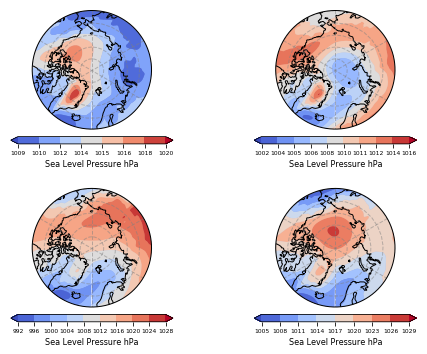

In [63]:
    print ('======================   plot the centers of K-mean   ======================')
    print ('======================    SLP original time series    ======================')
    fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(8,6),
                           subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
    lat_iris = iris.coords.DimCoord(latitude_ERAI_fields, standard_name='latitude',
                                    long_name='latitude', var_name='lat', units='degrees')
    lon_iris = iris.coords.DimCoord(longitude_ERAI_fields, standard_name='longitude', 
                                    long_name='longitude', var_name='lon', units='degrees')
    for i in np.arange(n_era):
        cube_iris = iris.cube.Cube(centers_spatial[i,:,:]/100, long_name='geographical field', var_name='field', 
                                   units='1', dim_coords_and_dims=[(lat_iris, 0), (lon_iris, 1)]) # hPa
        ax.flat[i].set_extent([-180,180,60,90],ccrs.PlateCarree())
        ax.flat[i].set_aspect('1')
        ax.flat[i].coastlines()
        gl = ax.flat[i].gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.flat[i].set_boundary(circle, transform=ax.flat[i].transAxes)        
        cs = iplt.contourf(cube_iris, axes=ax.flat[i], cmap='coolwarm', extend='both')
        cbar = fig.colorbar(cs, ax=ax.flat[i], extend='both', orientation='horizontal',
                            shrink =0.8, pad=0.05, format="%1.f")
        cbar.set_label('Sea Level Pressure hPa',size = 8)
        #cbar.set_ticks(ticks)
        cbar.ax.tick_params(labelsize = 6)
    iplt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_Kmean.png'), dpi=300)
    plt.close(fig)

In [71]:
    print ('======================   check the heat map of K-mean   ======================')
    print (clust_labels)
    print (len(clust_labels[clust_labels==3]))

======================   check the heat map of K-mean   ======================
[2 2 2 2 2 1 3 1 0 1 0 3 2 0 2 2 2 1 1 3 3 1 2 0 3 0 2 1 1 1 3 3 1 2 0 1 2
 0 0 1 2 1 3 3 3 1 0 0 0 0 0 2 2 3 3 3 1 3 1 0 0 0 2 2 1 1 1 3 1 0 0 0 2 2
 1 2 2 1 1 1 1 3 2 2 0 2 3 1 2 3 1 1 1 3 0 0 0 2 2 2 1 1 1 1 3 3 0 2 0 2 2
 2 2 3 1 3 3 3 0 3 3 3 0 2 1 3 3 3 3 3 0 0 0 0 3 3 3 1 1 1 1 3 1 0 0 0 2 1
 1 1 3 3 0 1 0 3 0 0 0 2 3 1 3 3 1 1 0 3 3 0 0 2 2 1 1 1 1 1 3 2 2 2 0 2 1
 3 3 3 3 3 3 0 0 0 0 2 2 1 1 3 1 1 1 1 0 3 1 2 1 1 3 3 2 0 0 2 0 0 0 1 2 1
 1 3 3 1 1 0 2 0 2 2 1 1 1 3 1 0 2 0 0 0 2 2 2 3 1 1 3 0 0 0 0 0 2 2 1 3 1
 1 3 0 2 2 0 2 2 1 1 1 3 3 1 0 3 0 0 0 1 1 1 3 3 1 3 1 2 0 0 0 0 1 1 1 3 3
 3 1 0 3 2 2 2 2 2 1 3 1 3 1 1 0 0 0 2 2 2 1 3 3 3 3 0 0 0 1 2 2 1 3 3 3 3
 1 0 3 0 2 0 1 1 1 1 3 1 3 2 0 0 0 2 2 2 1 1 3 1 3 0 0 0 2 2 1 1 1 1 1 3 2
 0 2 0 2 2 2 2 1 3 1 1 1 1 2 0 0 3 0 2 1 1 1 3 3 0 0 0 0 0 2 1 1 3 3 3 2 0
 2 2 2 2 2 1 3 1 3 1 3 3 0 0 0 0 3 1 1 1 1 3 2 0 0 0 0 0 1 1 1 1 1 3 3 0 0
 0 0 0 2 2 3 1 3 3 1 

The benchmark of the implementation of K-mean is listed above. Now we will apply this method to the seasonal anomalies of SLP from each reanalyses.<br>

Table for an easy lead / lag analysis of seasonal data <br>

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |winter|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JFM |FMA |MAM |AMJ |MJJ |JJA |JAS |ASO |SON |OND |NDJ |DJF   |

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |summer|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JAS |ASO |SON |OND |NDJ |DJF |JFM |FMA |MAM |AMJ |MJJ |JJA   |

In [4]:
    # simple calculator for seasonal lead/lag pairing
    lag_winter = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ',
                  'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
    lag_summer = ['JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ',
                  'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ']

Be cautious about the time across the year! The definition of lead/lag is the opposite to the one defined in the package.<br>
If y (fields) leads:<br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag -12 : x[2:] & y[:-2]<br>
...<br>
..........................................<br>
If x (MET) leads:<br>
winter (DJF) lag +1 : x[2:-1] & y[3:]<br>
winter (DJF) lag +2 : x[2:-1] & y[3:]<br>
...<br>
winter (DJF) lag +10 : x[2:-1] & y[3:]<br>
winter (DJF) lag +11 : x[2:-2] & y[4:]<br>
......................................................................<br>
If y (fields) leads:<br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -5 : x & y <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag -7 : x[3:] & y[1:-2] <br>
summer (JJA) lag -8 : x[3:] & y[:-3] <br>
...<br>
summer (JJA) lag -12 : x[3:] & y[:-3] <br>
..........................................<br>
If x (MET) leads:<br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +5 : x[:-1] & y[1:] <br>
summer (JJA) lag +6 : x[:-2] & y[2:] <br>
summer (JJA) lag +7 : x[:-3] & y[3:] <br>
...
summer (JJA) lag +11 : x[:-3] & y[3:] <br>

In [5]:
    print ('================   K-mean clustering of SLP anomalies in winter  ================')
    # get winter time series
    # ERA-Interim
    SLP_ERAI_season_series = meta.statistics.operator.seasons(SLP_ERAI[:,:lat_ERAI_60+1,:],
                                                              span='DJF', Dim_month=False)    
    stat_SLP_ERAI = meta.statistics.operator(SLP_ERAI_season_series[:])
    stat_SLP_ERAI.anomaly(Dim_month=False)
    #stat_OMET_ORAS4.detrend()
    #stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    # MERRA2
    SLP_MERRA2_season_series = meta.statistics.operator.seasons(SLP_MERRA2[:,lat_MERRA2_60:,:],
                                                                span='DJF', Dim_month=True)    
    stat_SLP_MERRA2 = meta.statistics.operator(SLP_MERRA2_season_series[:])
    stat_SLP_MERRA2.anomaly(Dim_month=False)
    # JRA55
    SLP_JRA55_season_series = meta.statistics.operator.seasons(SLP_JRA55[:,:,:lat_JRA55_60+1,:],
                                                               span='DJF', Dim_month=True)    
    stat_SLP_JRA55 = meta.statistics.operator(SLP_JRA55_season_series[:])
    stat_SLP_JRA55.anomaly(Dim_month=False)    
    # flatten the time series
    t_era, y_era, x_era = stat_SLP_ERAI._anomaly.shape
    stat_SLP_ERAI_anomaly_2D = np.reshape(stat_SLP_ERAI._anomaly,
                                          [t_era, y_era*x_era], order='F')
    t_merra, y_merra, x_merra = stat_SLP_MERRA2._anomaly.shape
    stat_SLP_MERRA2_anomaly_2D = np.reshape(stat_SLP_MERRA2._anomaly,
                                            [t_merra, y_merra*x_merra], order='F')
    t_jra, y_jra, x_jra = stat_SLP_JRA55._anomaly.shape
    stat_SLP_JRA55_anomaly_2D = np.reshape(stat_SLP_JRA55._anomaly,
                                          [t_jra, y_jra*x_jra], order='F')

================   K-mean clustering of SLP anomalies in winter  ================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!


/home/ESLT0068/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ESLT0068/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [6]:
    print ('======================   K-mean clustering   ======================')
    kmeans_era = KMeans(n_clusters=4, n_init=50)
    model_era = kmeans_era.fit(stat_SLP_ERAI_anomaly_2D)
    clust_labels_era = model_era.predict(stat_SLP_ERAI_anomaly_2D)
    print("ERA-Interim\n", model_era)

======================   K-mean clustering   ======================
ERA-Interim
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=50, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [7]:
    print ('===================   check the centers from K-mean clustering   ===================')
    centers_era = model_era.cluster_centers_
    n_era, nn_era = centers_era.shape
    # shape back to the spatial arrangement
    centers_spatial_era = np.reshape(centers_era,[n_era, y_era, x_era], order='F')

===================   check the centers from K-mean clustering   ===================


======================   plot the centers of K-mean   ======================
======================    SLP original time series    ======================


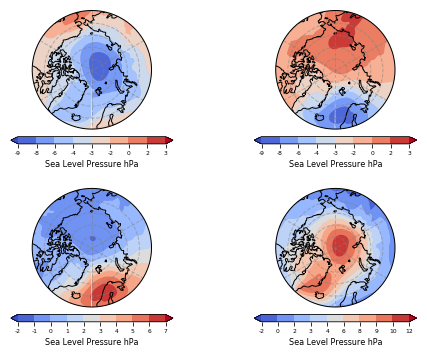

In [8]:
    print ('======================   plot the centers of K-mean   ======================')
    print ('======================    SLP original time series    ======================')
    fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(8,6),
                           subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
    lat_iris = iris.coords.DimCoord(latitude_ERAI_fields[:lat_ERAI_60+1], standard_name='latitude',
                                    long_name='latitude', var_name='lat', units='degrees')
    lon_iris = iris.coords.DimCoord(longitude_ERAI_fields, standard_name='longitude', 
                                    long_name='longitude', var_name='lon', units='degrees')
    for i in np.arange(n_era):
        cube_iris = iris.cube.Cube(centers_spatial_era[i,:,:]/100, long_name='geographical field', var_name='field', 
                                   units='1', dim_coords_and_dims=[(lat_iris, 0), (lon_iris, 1)]) # hPa
        ax.flat[i].set_extent([-180,180,60,90],ccrs.PlateCarree())
        ax.flat[i].set_aspect('1')
        ax.flat[i].coastlines()
        gl = ax.flat[i].gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.flat[i].set_boundary(circle, transform=ax.flat[i].transAxes)        
        cs = iplt.contourf(cube_iris, axes=ax.flat[i], cmap='coolwarm', extend='both')
        cbar = fig.colorbar(cs, ax=ax.flat[i], extend='both', orientation='horizontal',
                            shrink =0.8, pad=0.05, format="%1.f")
        cbar.set_label('Sea Level Pressure hPa',size = 8)
        #cbar.set_ticks(ticks)
        cbar.ax.tick_params(labelsize = 6)
    iplt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_anomaly_DJF_Kmean.png'), dpi=300)
    plt.close(fig)

======================   plot the centers of K-mean   ======================
======================  Atlantic ocean only zoom in   ======================
======================    SLP original time series    ======================


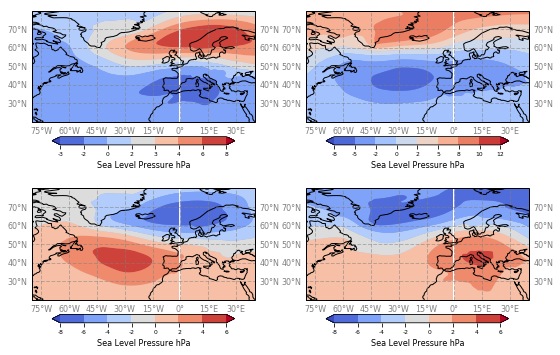

In [46]:
    print ('======================   plot the centers of K-mean   ======================')
    print ('======================  Atlantic ocean only zoom in   ======================')
    print ('======================    SLP original time series    ======================')
    print ('======================         only for a check       ======================')
    fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(9,6),
                           subplot_kw=dict(projection=ccrs.PlateCarree()))
    lat_iris = iris.coords.DimCoord(latitude_ERAI_fields, standard_name='latitude',
                                    long_name='latitude', var_name='lat', units='degrees')
    lon_iris = iris.coords.DimCoord(longitude_ERAI_fields, standard_name='longitude', 
                                    long_name='longitude', var_name='lon', units='degrees')
    for i in np.arange(n_era):
        cube_iris = iris.cube.Cube(centers_spatial_era[i,:,:]/100, long_name='geographical field', var_name='field', 
                                   units='1', dim_coords_and_dims=[(lat_iris, 0), (lon_iris, 1)]) # hPa
        ax.flat[i].set_extent([-80,40,20,80],ccrs.PlateCarree())
        ax.flat[i].set_aspect('1')
        ax.flat[i].coastlines()
        gl = ax.flat[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 8, 'color': 'gray'}
        gl.ylabel_style = {'size': 8, 'color': 'gray'}
        cs = iplt.contourf(cube_iris, axes=ax.flat[i], cmap='coolwarm', extend='both')
        cbar = fig.colorbar(cs, ax=ax.flat[i], extend='both', orientation='horizontal',
                            shrink =0.8, pad=0.1, format="%1.f")
        cbar.set_label('Sea Level Pressure hPa',size = 8)
        #cbar.set_ticks(ticks)
        cbar.ax.tick_params(labelsize = 6)
    iplt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_anomaly_DJF_Kmean_atlantic.png'), dpi=300)
    plt.close(fig)

In [9]:
    print ('======================   check the heat map of K-mean   ======================')
    print ('ERA-Interim')
    print (clust_labels_era)
    print ('mode 1', len(clust_labels_era[clust_labels_era==0])/len(clust_labels_era))
    print ('mode 2', len(clust_labels_era[clust_labels_era==1])/len(clust_labels_era))
    print ('mode 3', len(clust_labels_era[clust_labels_era==2])/len(clust_labels_era))
    print ('mode 4', len(clust_labels_era[clust_labels_era==3])/len(clust_labels_era))
    #print ('mode 5', len(clust_labels_era[clust_labels_era==4])/len(clust_labels_era))
    #print ('mode 6', len(clust_labels_era[clust_labels_era==5])/len(clust_labels_era))
    #print ('mode 7', len(clust_labels_era[clust_labels_era==6])/len(clust_labels_era))
    #print ('mode 8', len(clust_labels_era[clust_labels_era==7])/len(clust_labels_era))

======================   check the heat map of K-mean   ======================
ERA-Interim
[3 2 0 3 2 1 0 2 2 2 0 1 1 2 2 1 2 2 3 3 3 1 2 2 2 3 3 0 2 0 0 0 1 1 0 1 1
 2 0 0 1 0 0 0 1 3 2 0 1 1 2 2 0 3 2 1 0 3 1 1 2 1 1 1 1 3 2 2 2 0 1 2 2 2
 2 3 3 1 1 2 2 0 2 0 0 3 2 0 1 2 2 2 3 2 3 3 2 0 1 2 2 3 3 2 0 2 1 1 1 0 1
 2 1 0]
mode 1 0.21929824561403508
mode 2 0.2631578947368421
mode 3 0.3508771929824561
mode 4 0.16666666666666666


==================   projection of data back to the cluster   ==================
==================   the eigen values are euclidean distance  ==================
================== short distance means close to the pattern  ==================


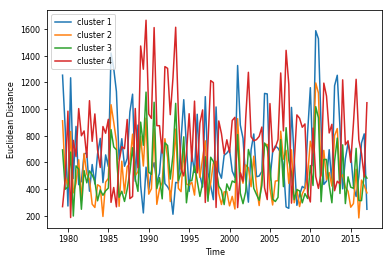

In [10]:
    print ('==================   projection of data back to the cluster   ==================')
    print ('==================   the eigen values are euclidean distance  ==================')
    print ('================== short distance means close to the pattern  ==================')
    SLP_ERAI_Kmean_proj = np.zeros((4,len(clust_labels_era)), dtype=float)
    for i in np.arange(4):
        mode = centers_spatial_era[i,:,:]
        mode_3D = np.repeat(mode[np.newaxis,:,:],len(clust_labels_era),0)
        SLP_ERAI_Kmean_proj[i,:] = np.mean(np.mean(np.abs(mode_3D-stat_SLP_ERAI._anomaly),2),1)

    index_full = np.arange(1,445,1)
    index_year = np.arange(1980,2016,5)
    index_full_season = np.arange(1,115,1)        
        
    fig = plt.figure(figsize=(6,4))
    for i in np.arange(4):
        plt.plot(index_full_season,SLP_ERAI_Kmean_proj[i,:],label='cluster {}'.format(i+1))
    plt.xlabel("Time",fontsize=8)
    plt.xticks(np.arange(3,len(year_ERAI)*3+3+1,15),index_year,fontsize=8)
    plt.ylabel("Euclidean Distance",fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(frameon=True, loc=2, prop={'size': 8})
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.show()
    fig.savefig(os.path.join(output_path,'ERAI_SLP_anomaly_DJF_Kmean_eigen.png'),dpi=300)
    plt.close(fig)

==================  pick-up AMET w.r.t. clustering  ==================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
AMET cluster 1
mean -0.07585554395656752
std 0.4047396015751503
AMET cluster 2
mean -0.05429461603009901
std 0.324165204206137
AMET cluster 3
mean 0.06877969897350912
std 0.41978512937283174
AMET cluster 4
mean 0.04073890109877922
std 0.3056268213242707


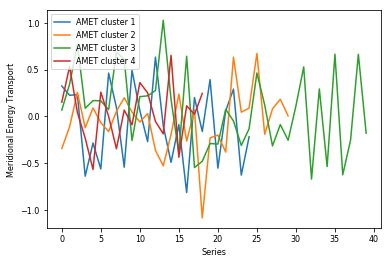

==================  PDF of AMET w.r.t. clustering  ==================


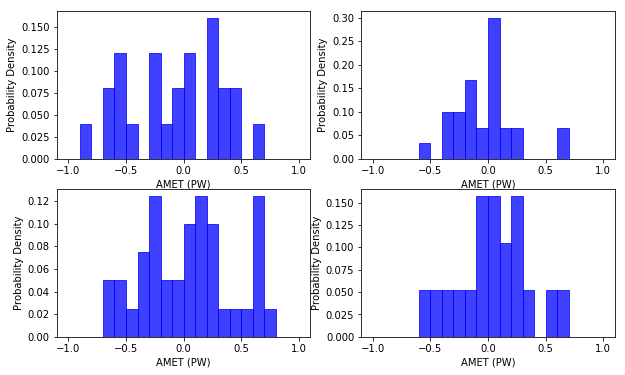

=========  Computes the Kolmogorov-Smirnov statistic on 2 AMET cluster samples ========
Kolmogorov-Smirnov statistic
mode 1 and 2
p-value 0.43402816331459304
Kolmogorov-Smirnov statistic
mode 2 and 3
p-value 0.12408736173866391
Kolmogorov-Smirnov statistic
mode 3 and 4
p-value 0.8296616422961075
==================  regression of AMET on the SLP w.r.t. clustering ================
ERA-Interim cluster 0
regression coefficient (Pa/PW)
0.0001221262592812479
correlation coefficient
0.06458461118058344
t-test
0.7590634345903804
ERA-Interim cluster 1
regression coefficient (Pa/PW)
0.000575781838185164
correlation coefficient
0.33276580713871157
t-test
0.07236928363884995
ERA-Interim cluster 2
regression coefficient (Pa/PW)
-0.0008653087726672544
correlation coefficient
-0.3485072131664477
t-test
0.02753365551548071
ERA-Interim cluster 3
regression coefficient (Pa/PW)
4.113954918800725e-05
correlation coefficient
0.02321429011318525
t-test
0.9248460124919755
==================  regression of AM

In [11]:
    print ('==================  pick-up AMET w.r.t. clustering  ==================')
    AMET_ERAI_season_series = meta.statistics.operator.seasons(AMET_ERAI,
                                                               span='DJF', Dim_month=True)    
    stat_AMET_ERAI = meta.statistics.operator(AMET_ERAI_season_series[:])
    stat_AMET_ERAI.anomaly(Dim_month=False)
    
    fig = plt.figure(figsize=(6,4))
    for i in np.arange(4):
        index_mode = np.where(clust_labels_era==i)
        plt.plot(np.arange(len(clust_labels_era[clust_labels_era==i])),
                 stat_AMET_ERAI._anomaly[index_mode],label='AMET cluster {}'.format(i+1))
        print('AMET cluster {}'.format(i+1))
        print('mean', np.mean(stat_AMET_ERAI._anomaly[index_mode]))
        print('std', np.std(stat_AMET_ERAI._anomaly[index_mode]))
    plt.xlabel("Series",fontsize=8)
    plt.xticks(np.arange(0,41,5),fontsize=8)
    plt.ylabel("Meridional Energy Transport",fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(frameon=True, loc=2, prop={'size': 8})
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    plt.show()
    fig.savefig(os.path.join(output_path,'ERAI_DJF_Kmean_cluster_AMET.png'),dpi=300)
    plt.close(fig)
    
    print ('==================  PDF of AMET w.r.t. clustering  ==================')
    fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(10,6))
    for i in np.arange(4):
        index_mode = np.where(clust_labels_era==i)
        AMET_select = stat_AMET_ERAI._anomaly[index_mode]
        # make the probability density sum to be 1
        weights = np.ones_like(AMET_select)/float(len(AMET_select))
        # best fit of data
        #mu, sigma = stats.norm.fit(AMET_select, weights=weights)
        n, bins, patches = ax.flat[i].hist(AMET_select, bins=20, range=(-1.0,1.0), weights=weights,
                        facecolor='b', edgecolor='b', alpha=0.75)
        # add a 'best fit' line
        #ax.flat[i].plot(bins, yy, 'r', linewidth=2)
        ax.flat[i].set_xlabel("AMET (PW)")
        ax.flat[i].set_ylabel("Probability Density")
    plt.show()
    fig.savefig(os.path.join(output_path,'ERAI_DJF_Kmean_cluster_AMET_pdf.png'), dpi=300)
    plt.close(fig)
    print ('=========  Computes the Kolmogorov-Smirnov statistic on 2 AMET cluster samples ========')
    # https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
    # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ks_2samp.html
    # null hypothesis
    # the samples are drawn from the same distribution
    for i in np.arange(4):
        if i<3:
            index_mode_1 = np.where(clust_labels_era==i)
            index_mode_2 = np.where(clust_labels_era==i+1)
            series_1 = stat_AMET_ERAI._anomaly[index_mode_1]
            series_2 = stat_AMET_ERAI._anomaly[index_mode_2]
            D, p_value = stats.ks_2samp(series_1, series_2)
            print ('Kolmogorov-Smirnov statistic')
            print ('mode {} and {}'.format(i+1,i+2))
            print ('p-value', p_value)
            i+=1
    print ('==================  regression of AMET on the SLP w.r.t. clustering ================')
    # linear regression
    #ERA-Interim
    for i in np.arange(4):
        index_mode = np.where(clust_labels_era==i)
        SLP_ERAI_mean = np.mean(np.mean(stat_SLP_ERAI._anomaly[:],2),1)
        slope, _, r_value, p_value, _ = stats.linregress(SLP_ERAI_mean[index_mode],
                                                         stat_AMET_ERAI._anomaly[index_mode])
        print ('ERA-Interim cluster {}'.format(i))
        print ('regression coefficient (Pa/PW)')
        print (slope)
        print ('correlation coefficient')
        print (r_value)
        print ('t-test')
        print (p_value)        
    print ('==================  regression of AMET on the SLP projection  ==================')
    # linear regression
    #ERA-Interim
    for i in np.arange(4):
        slope, _, r_value, p_value, _ = stats.linregress(SLP_ERAI_Kmean_proj[i,:],
                                                         stat_AMET_ERAI._anomaly)
        print ('ERA-Interim cluster {}'.format(i))
        print ('regression coefficient (Pa/PW)')
        print (slope)
        print ('correlation coefficient')
        print (r_value)
        print ('t-test')
        print (p_value)    